**Table of Contents**  
[Data loading](#data_loading)  
[Median normalization](#median_normalization)  
[Batch effect removal](#batch_effect_removal)  
[Dimensionality reduction](#dimensionality_reduction)  
&nbsp; &nbsp; &nbsp; &nbsp;[PCA](#pca)  
&nbsp; &nbsp; &nbsp; &nbsp;[t-SNE](#t-sne)  
&nbsp; &nbsp; &nbsp; &nbsp;[UMAP](#umap)  
[Clustering](#clustering)  
[Visualization](#visualization)  

In [1]:
!date +%F

2019-07-01


In [2]:
import sys
import re
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.sparse
import sklearn.manifold

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
print(sys.version)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
print('sklearn', sklearn.__version__)
print('matplotlib', mpl.__version__)
print('seaborn', sns.__version__)

3.7.3 (default, Apr 19 2019, 19:12:31) 
[Clang 10.0.1 (clang-1001.0.46.4)]
numpy 1.16.4
pandas 0.24.2
scipy 1.3.0
sklearn 0.21.2
matplotlib 3.1.0
seaborn 0.9.0


In [4]:
# sc.logging.print_versions()
import scanpy as sc
import umap

print('scanpy', sc.__version__)
print('umap', umap.__version__)

scanpy 1.4.3
umap 0.3.9


In [5]:
if not 'mpl_orig_params' in dir():
    mpl_orig_params = plt.rcParams

params = {'pdf.fonttype': 42,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial',
          'mathtext.default': 'regular',
          'figure.dpi': 96 * 1.5,
          'axes.axisbelow': True}          
plt.rcParams.update(params)

<a id='data_loading'></a>

# Data loading

In [6]:
# read in gene annotation
features = [i.rstrip().split('\t')[0] + '_' + i.rstrip().split('\t')[1] 
            for i in open(file='../../data/misc/genes.tsv', mode='r')]
features = np.array(object=features)

In [7]:
data_directory = Path('../../data/drop-seq/')

expr_readcount_use = scipy.sparse.load_npz(file=data_directory / 'expr_readcount_raw_csc.npz')
expr_readcount_use.shape

(27999, 27416)

In [8]:
_, expr_readcount_use_colnames \
    = np.load(file=data_directory / 'expr_readcount_raw_csc_dimnames.npy',
              allow_pickle=True)

<a id='median_normalization'></a>

# Median normalization

In [9]:
expr_readcount_norm = expr_readcount_use.copy()
print('Raw median UMIs per cell is {}'.format(np.median(a=expr_readcount_use.sum(axis=0).A1)))

# filter
col_idx, = np.where((expr_readcount_norm > 0).sum(axis=0).A1 >= 200)
expr_readcount_norm_colnames = expr_readcount_use_colnames[col_idx]
expr_readcount_norm = expr_readcount_norm[:,col_idx]

row_idx = np.logical_and((expr_readcount_norm > 0).sum(axis=1).A1 >= 30,
                         (expr_readcount_norm).sum(axis=1).A1 >= 60)
expr_readcount_norm = expr_readcount_norm[row_idx,]

expr_readcount_norm_features = features[row_idx]

print('After filtering, median UMIs per cell is {}'.format(np.median(a=expr_readcount_norm.sum(axis=0).A1)))
expr_readcount_norm.shape

Raw median UMIs per cell is 3608.0
After filtering, median UMIs per cell is 4001.5


(16535, 25776)

In [10]:
# normalize
expr_readcount_norm.data = np.median(a=expr_readcount_norm.sum(axis=0).A1) * \
    expr_readcount_norm.data / np.repeat(expr_readcount_norm.sum(axis=0).A1, np.diff(expr_readcount_norm.indptr))

# reselect cells
cells_included = expr_readcount_norm_colnames

<a id='batch_effect_removal'></a>

# Batch effect removal

In [11]:
# create anndata object, logarithmized
expr_readcount_norm_log = sc.AnnData(X=np.log1p(expr_readcount_norm.T),
                                     obs={'cell': cells_included,
                                          'batch': [re.sub('_[A-Z]{12}\.bam', '', i) for i in cells_included]},
                                     var={'gene': expr_readcount_norm_features})

In [12]:
print('Total batches: {}'.format(expr_readcount_norm_log.obs['batch'].nunique()))

expr_readcount_norm_log_corrected = sc.pp.combat(adata=expr_readcount_norm_log,
                                                 key='batch',
                                                 inplace=False)
expr_readcount_norm_log_corrected.shape

Total batches: 93


... storing 'batch' as categorical
/Users/jialei/.pyenv/versions/3.7.3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:269: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_it_sol" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for 'sum2', defined at /Users/jialei/.pyenv/versions/3.7.3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (311)

File "../../../../../../../../../../.pyenv/versions/3.7.3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 311:
def _it_sol(s_data, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001) -> Tuple[float, float]:
    <source elided>
        g_new = (t2*n*g_hat + d_old*g_bar) / (t2*n + d_old)
        sum2 = s_data - g_new.reshape((g_new.shape[0], 1)) @ np.ones((1, s_data.shape[1]))
        ^

[1] During: typing of assignment at /Users/jialei/.pyenv/versions/3.7.3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (313)

(25776, 16535)

<a id='dimensionality_reduction'></a>

# Dimensionality reduction

In [13]:
# standardize
expr_readcount_norm_log_corrected_std = StandardScaler(copy=True, 
                                                       with_mean=True, 
                                                       with_std=True).fit_transform(expr_readcount_norm_log_corrected)

<a id='pca'></a>

In [14]:
seed_use = 20190701

## PCA

In [15]:
pca_out = PCA(n_components=None,
              copy=True,
              whiten=False,
              svd_solver='auto',
              tol=0.0,
              iterated_power='auto',
              random_state=seed_use)

pcs = pca_out.fit_transform(expr_readcount_norm_log_corrected_std)

<a id='t-sne'></a>

## t-SNE

In [16]:
num_pcs = 10

In [17]:
embedding_tsne = TSNE(n_components=2,
                      perplexity=30.0,
                      early_exaggeration=12.0,
                      learning_rate=200.0,
                      n_iter=3000,
                      n_iter_without_progress=300,
                      min_grad_norm=1e-07,
                      metric='euclidean',
                      init='random',
                      verbose=1,
                      random_state=seed_use,
                      method='barnes_hut',
                      angle=0.5).fit_transform(pcs[:,range(num_pcs)])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25776 samples in 0.022s...
[t-SNE] Computed neighbors for 25776 samples in 4.956s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25776
[t-SNE] Computed conditional probabilities for sample 2000 / 25776
[t-SNE] Computed conditional probabilities for sample 3000 / 25776
[t-SNE] Computed conditional probabilities for sample 4000 / 25776
[t-SNE] Computed conditional probabilities for sample 5000 / 25776
[t-SNE] Computed conditional probabilities for sample 6000 / 25776
[t-SNE] Computed conditional probabilities for sample 7000 / 25776
[t-SNE] Computed conditional probabilities for sample 8000 / 25776
[t-SNE] Computed conditional probabilities for sample 9000 / 25776
[t-SNE] Computed conditional probabilities for sample 10000 / 25776
[t-SNE] Computed conditional probabilities for sample 11000 / 25776
[t-SNE] Computed conditional probabilities for sample 12000 / 25776
[t-SNE] Computed conditional probabilities for sam

<a id='umap'></a>

## UMAP

In [18]:
embedding_umap = umap.UMAP(n_neighbors=10,
                           min_dist=0.1,
                           n_components=2,
                           metric='euclidean',
                           random_state=seed_use,
                           verbose=True).fit_transform(pcs[:,range(num_pcs)])

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=10, negative_sample_rate=5, random_state=20190701,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Tue Jul  2 00:12:29 2019 Finding Nearest Neighbors
Tue Jul  2 00:12:29 2019 Building RP forest with 13 trees


/Users/jialei/.pyenv/versions/3.7.3/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/jialei/.pyenv/versions/3.7.3/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../../../../../../../../.pyenv/versions/3.7.3/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursi

Tue Jul  2 00:12:32 2019 NN descent for 15 iterations


/Users/jialei/.pyenv/versions/3.7.3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../.pyenv/versions/3.7.3/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/Users/jialei/.pyenv/versions/3.7.3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.

	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
Tue Jul  2 00:12:35 2019 Finished Nearest Neighbor Search


/Users/jialei/.pyenv/versions/3.7.3/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../../../../../.pyenv/versions/3.7.3/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/jialei/.pyenv/versions/3.7.3/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../../../../../.pyenv/versions/3.7.3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/jialei/.pyenv/ver

Tue Jul  2 00:12:38 2019 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Jul  2 00:12:55 2019 Finished embedding


<a id='clustering'></a>

# Clustering

In [19]:
mat = sc.AnnData(X=pcs[:,range(num_pcs)],
                 obs={'cell': cells_included,
                      'batch': [re.sub('_[A-Z]{12}\.bam', '', i) for i in cells_included]})

In [20]:
sc.pp.neighbors(adata=mat,
                n_neighbors=30,
                n_pcs=0,
                # use_rep=None,
                knn=True,
                random_state=seed_use,
                method='umap',
                metric='euclidean',
                copy=False)

/Users/jialei/.pyenv/versions/3.7.3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../.pyenv/versions/3.7.3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/Users/jialei/.pyenv/versions/3.7.3/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../../../../../.pyenv/versions/3.7.3/lib/python3.7/site-packages/umap/umap_.py", line 467:
d

In [21]:
sc.tl.louvain(adata=mat,
              resolution=None,
              random_state=seed_use,
              flavor='vtraag',
              directed=True,
              use_weights=False,
              partition_type=None,
              copy=False)

In [22]:
mat.obs['louvain'].value_counts()

0     3313
1     3107
2     2748
3     2547
4     2535
5     2383
6     2230
7     2043
8     1154
9      700
10     662
11     617
12     472
13     470
14     419
15     169
16     127
17      80
Name: louvain, dtype: int64

<a id='visualization'></a>

# Visualization

In [23]:
embedding = pd.DataFrame(np.concatenate((embedding_tsne, embedding_umap), axis=1),
                         columns=['x_t-sne', 'y_t-sne', 'x_umap', 'y_umap'],
                         index=cells_included)

embedding['cluster'] = mat.obs_vector('louvain').astype(np.int) + 1

In [24]:
if not Path('embedding.csv').is_file():
    embedding.to_csv('embedding.csv')

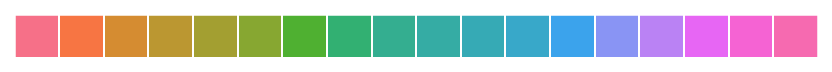

In [25]:
sns.set(context='notebook',
        style='darkgrid', 
        palette='deep', 
        font='sans-serif', 
        font_scale=1, 
        color_codes=True, 
        rc=None)

cluster_labels = embedding.groupby('cluster').median()

cluster_colors = sns.color_palette(palette='husl', n_colors=embedding['cluster'].nunique())
sns.palplot(pal=cluster_colors, size=0.4)

embedding['color'] = embedding['cluster'].map({i + 1: j for i, j in enumerate(cluster_colors)})

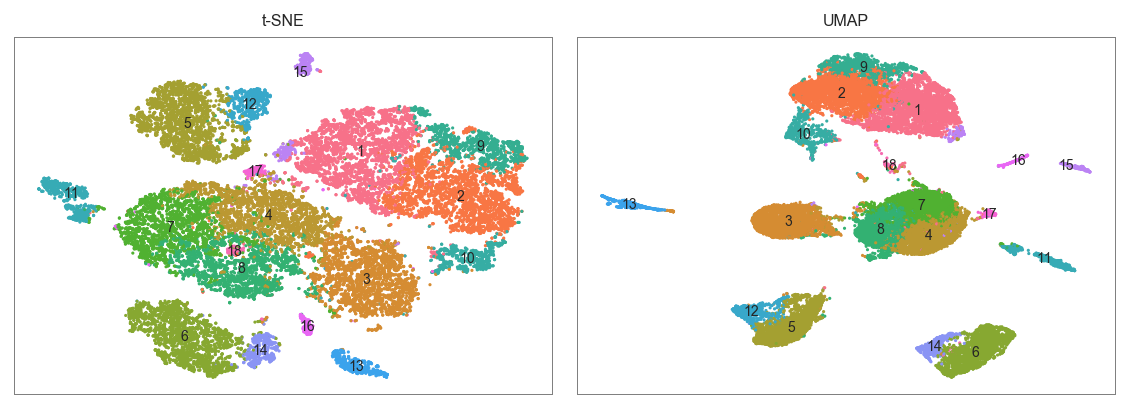

In [26]:
vis_methods = ['t-SNE', 'UMAP']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    
for index, value in enumerate(vis_methods):

    axes[index].scatter(x=embedding['x_' + value.lower()],
                        y=embedding['y_' + value.lower()],
                        s=10,
                        marker='.',
                        color=embedding.color,
                        alpha=1,
                        linewidths=0,
                        rasterized=False,
                        edgecolors=None)
    
    for i in cluster_labels.index:
        axes[index].annotate(s=str(i),
                             xy=(cluster_labels.loc[i]['x_' + value.lower()],
                                 cluster_labels.loc[i]['y_' + value.lower()]),
                             fontsize=7,
                             horizontalalignment='center',
                             verticalalignment='center')
    
    axes[index].set_title(label=value, fontdict=None, loc='center', fontsize=8)
    axes[index].set_facecolor('white')
    
    for i in ['top','bottom','left','right']:
        axes[index].spines[i].set_linewidth(w=0.5)
        axes[index].spines[i].set_color('grey')

        axes[index].xaxis.set_ticks([])
        axes[index].yaxis.set_ticks([])
        
plt.tight_layout()

In [27]:
if not Path('Pyplot_embedding_tsne_umap.pdf').is_file():
    fig.savefig(fname='Pyplot_embedding_tsne_umap.pdf',
                transparent=None,
                bbox_inches='tight')